In [1]:
from saicinpainting.training.trainers import load_checkpoint
from saicinpainting.evaluation.refinement import (
    refine_predict,
)  # refining the predictions

from omegaconf import OmegaConf
import yaml, torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2
import albumentations as A
%matplotlib inline
from IPython import display

In [2]:
# for toastmaster's image
# image = plt.imread("testing_imgs/toastmasters_test_image.JPG")
# flip_it = A.Compose([
#     A.HorizontalFlip(),
#     A.VerticalFlip()
# ])
# image = flip_it(image=image)["image"]
# mask = plt.imread("testing_masks/marc_mask.png")
# mask = mask[:,:,:-1] # remove 4th dim which is confidence
# mask.shape

In [81]:
img_prefix = "boat"
model_str = "pose2segtrans" # or pose2seg or SAM or pose2segtrans
path_to_masks = "testing_masks"

In [82]:
mask = plt.imread(path_to_masks +"/" + model_str+"_output/"+ img_prefix +"_"+model_str+"_mask.jpg")
mask = mask / 256
mask = mask.astype(np.float32) # must be float32 for LAMA inference
# mask = np.load("testing_masks/" + img_prefix + "_mask.npy",allow_pickle=True)
# Don't use npy! it messes things up!
image = plt.imread("testing_imgs/" + img_prefix + ".jpg")

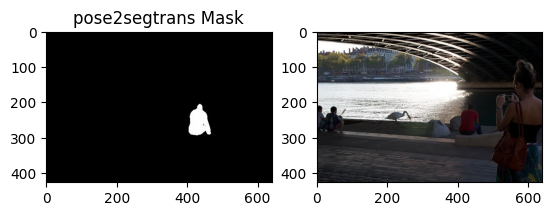

In [83]:
plt.subplot(1,2,1)
plt.imshow(mask,cmap='gray')
plt.title(model_str+" Mask")
plt.subplot(1,2,2)
plt.imshow(image)
plt.show()

#### Make the Mask larger

In [31]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(mask,kernel,iterations=3)

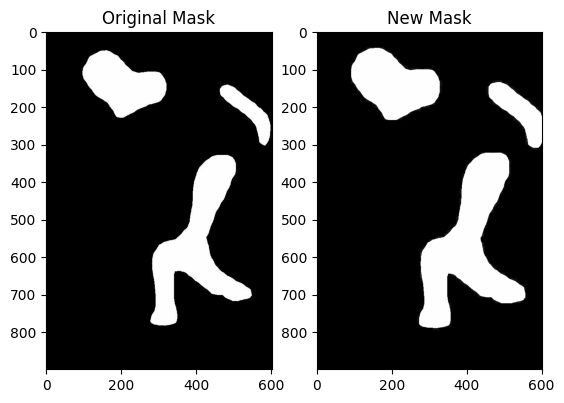

In [32]:
plt.subplot(1,2,1)
plt.imshow(mask)
plt.title("Original Mask")
plt.subplot(1,2,2)
plt.title("New Mask")
plt.imshow(dilation)
plt.show()

In [33]:
mask = dilation

### Preprocess the Images

In [84]:
tensor_maker = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((512, 512))
    ]
)
tensor_img = tensor_maker(image)
tensor_mask = transforms.Grayscale()(tensor_maker(mask))

c:\Users\Aditya Ojha\Music\CV_Graduate\lama\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [85]:
# make the batch size 1
test_img = torch.unsqueeze(tensor_img, 0)
test_mask = torch.unsqueeze(tensor_mask, 0)
# package data into a dict for model inference
test_batch = {
        "image": test_img,
        "mask": test_mask,
    }  

In [86]:
test_img.size(),test_mask.size()

(torch.Size([1, 3, 512, 512]), torch.Size([1, 1, 512, 512]))

### Stuff for Model

In [9]:
def resolve_torchpath(arg):
    if arg == "TORCH_HOME":
        return "C:\\Users\\Aditya Ojha\\Music\\CV_Graduate\\lama\\"
    else:
        print(arg)
        return None
OmegaConf.register_new_resolver("env", resolve_torchpath) # do this for the config files to work
# it basically tells the code where to find the pytorch installation
with open("big-lama/config.yaml", "r") as f:
    train_config = OmegaConf.create(yaml.safe_load(f))
model = load_checkpoint(
    train_config=train_config,
    path="big-lama/models/best.ckpt",
    strict=False,
    map_location="cpu",
)

USER
USER
USER
USER


c:\Users\Aditya Ojha\Music\CV_Graduate\lama\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aditya Ojha\Music\CV_Graduate\lama\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Aditya Ojha\Music\CV_Graduate\lama\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Adit

Loading weights for net_encoder


### Make Predictions

In [87]:
output = model(test_batch)  # get prediction
img_pred = output["predicted_image"]
inpaint = output["inpainted"]

masked image size  torch.Size([1, 4, 512, 512])
mask size is  torch.Size([1, 1, 512, 512])
predicted_image size is  torch.Size([1, 3, 512, 512])
image size is  torch.Size([1, 3, 512, 512])


In [88]:
img_pred = torch.squeeze(img_pred) # remove batch
inpaint = torch.squeeze(inpaint) # remove batch
img_pred.size(),inpaint.size()

(torch.Size([3, 512, 512]), torch.Size([3, 512, 512]))

In [89]:
def detach_and_process(tensor):
    result = img_pred.detach().numpy()
    result = np.transpose(result,(1,2,0))
    return result
img_pred_np = detach_and_process(img_pred)
inpaint_np = detach_and_process(inpaint)
# img_pred_np = cv2.cvtColor(img_pred_np,cv2.COLOR_BGR2RGB)

In [90]:
img_pred_np = np.clip(img_pred_np * 255, 0, 255).astype('uint8')
inpaint_np = np.clip(inpaint_np * 255, 0, 255).astype('uint8')

### Look and Inputs/Outputs Together

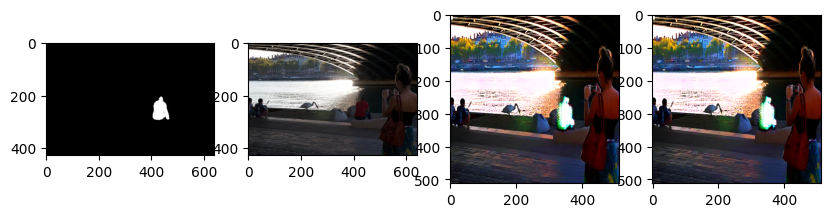

In [91]:
nrows = 4
ncols = 1
plt.figure(figsize=(10,10))
plt.subplot(1,nrows,1)
plt.imshow(mask,cmap='gray')
plt.subplot(1,nrows,2)
plt.imshow(image)
plt.subplot(1,nrows,3)
plt.imshow(img_pred_np)
plt.subplot(1,nrows,4)
plt.imshow(inpaint_np)
plt.savefig(model_str+"_LAMA_"+img_prefix+"_dilation.jpg")
plt.show()

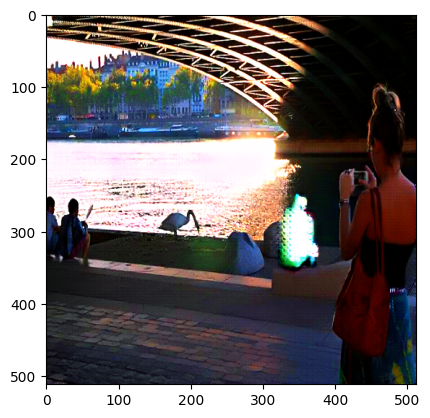

In [92]:
# np.max(inpaint_np)
plt.imshow(inpaint_np)
plt.imsave("example_outputs/"+img_prefix+"_"+model_str+"_LAMA_output.jpg",inpaint_np)
plt.show()